# Edit Railways and view graphs


In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
from collections import OrderedDict
from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.utils.rendertools import RenderTool
from PIL import Image
import networkx as nx
import json
from numpy import array
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from ipywidgets import Button, HBox, VBox
from flatland.utils.graph_utils import RailEnvGraph, trans_int_to_4x4, trans_int_to_binstr, trans_int_to_nesw, get_rail_transitions_df
from flatland.utils.graph_utils import get_simple_path, plotGraphEnv
import flatland.utils.graph_utils as gu
from flatland.envs.rail_generators import rail_from_manual_specifications_generator
from flatland.envs.rail_generators import random_rail_generator, complex_rail_generator, sparse_rail_generator, empty_rail_generator
from flatland.utils.editor import EditorMVC
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
from flatland.utils.editor import EditorMVC

In [4]:
mvc = EditorMVC(sGL="PILSVG" ) 

/home/jeremy/projects/aicrowd/rl-trains/flatland/flatland/utils/rendertools.py:450: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


## Instructions
- Drag to draw (improved dead-ends)
- ctrl-click to add agent or select agent
  - if agent is selected:
    - ctrl-click to move agent position
    - use rotate agent to rotate 90° 
    - ctrl-shift-click to set target for selected agent 
      - target can be moved by repeating
- to Resize the env (cannot preserve work):
  - select "Regen" tab, set regen size slider, click regenerate.
- alt-click remove all rails from cell 


Demo Scene: complex_scene.pkl


In [5]:
env = RailEnv(width=20, height=20, rail_generator=empty_rail_generator(), number_of_agents=0,
                          obs_builder_object=TreeObsForRailEnv(max_depth=2))

In [6]:
#env.reset()
#env.load("g3.pkl")

In [7]:
mvc = EditorMVC(sGL="PILSVG", env=env, env_filename="g4.mpk") 

In [8]:
mvc.view.display()

In [11]:
# Run this cell if you would like to see debug output
mvc.view.output_generator.clear_output()
mvc.view.output_generator

Output(outputs=({'output_type': 'stream', 'text': 'load file:  g4.mpk\nRegenerate size 50 30\n', 'name': 'stdo…

In [12]:
#display(mvc.view.debug)
#display(mvc.view.debug_move)

In [13]:
env = mvc.editor.env

In [14]:
gEnv = RailEnvGraph(env)
G = gEnv.G
[ (n,d) for n, d in G.nodes(data=True) if "type" not in d ]

[]

In [15]:
mvc.view.oRT.render_env(show_agents=True, show_observations=False, show_predictions=False, show_inactive_agents=True)
aImg = mvc.view.oRT.get_image()

In [18]:
#Image.fromarray(aImg)

In [19]:
G2 = gEnv.graph_rail_grid()

In [20]:
G = gEnv.G

In [21]:
[ (n,d) for n, d in G.nodes(data=True) if "type" not in d ]

[]

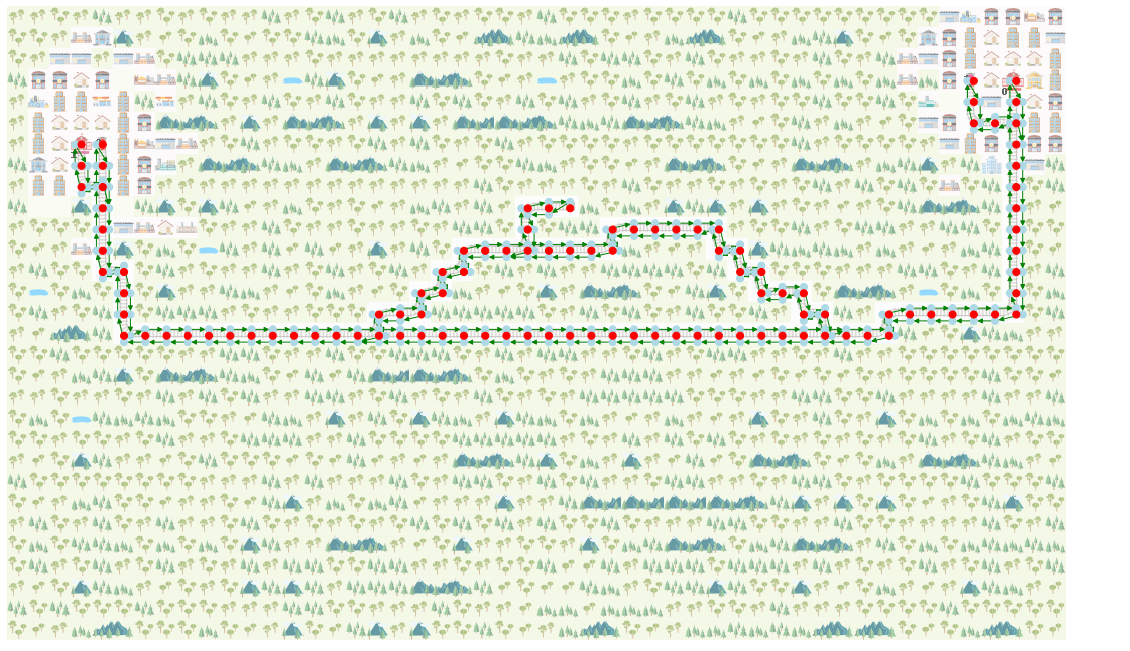

In [25]:
plotGraphEnv(G2, env, aImg, node_size=50, alpha_img=0.6, figsize=(20,20))

In [23]:
gEnv.savejson("g4-railgrid-long.json", alt_graph=G2)

In [26]:
G5 = gEnv.reduce_simple_paths()

In [28]:
gEnv.savejson("g4-short.json", alt_graph=G5)

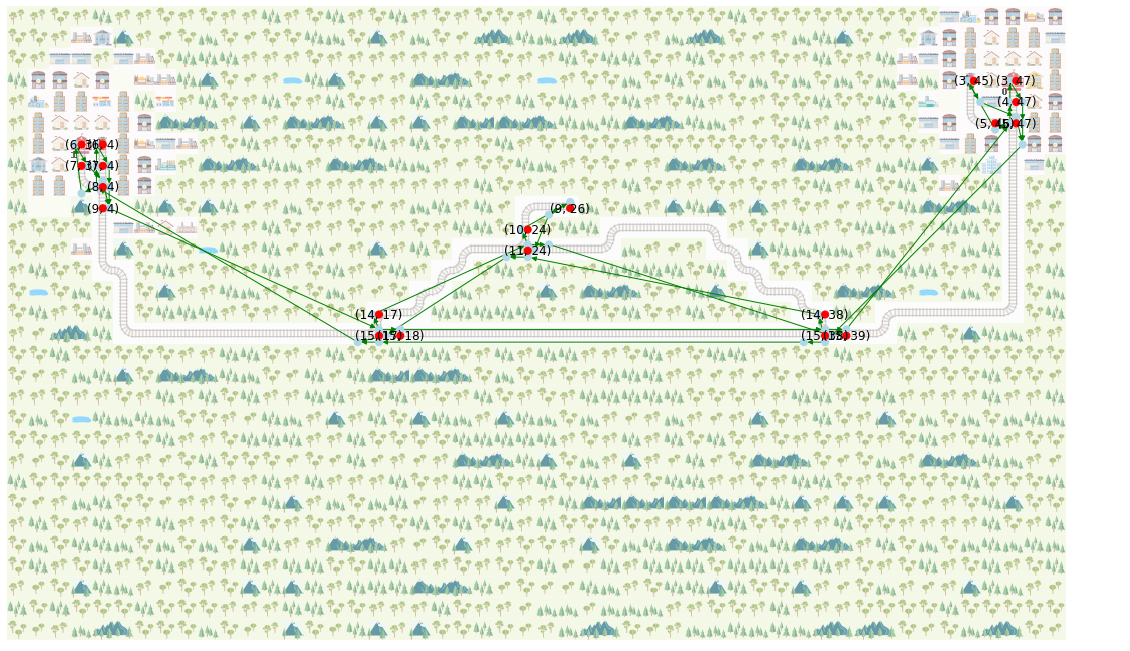

In [91]:
plotGraphEnv(G5, env, aImg, node_size=50, alpha_img=0.6, figsize=(20,20), show_labels=("grid"))

In [24]:
gEnv.savejson(filename="g3.json", alt_graph=G5)

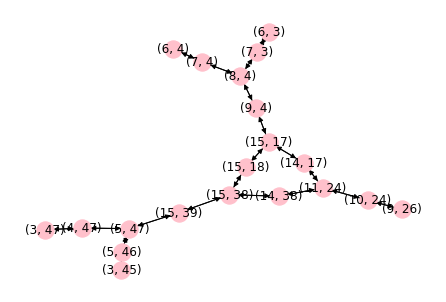

In [25]:
G5b = nx.induced_subgraph(G5, [ n for n, d in G5.nodes(data=True) if d["type"]=="grid" ])
gEnv.savejson(filename="g3_grid.json", alt_graph=G5b)
nx.draw(G5b, with_labels=True, node_color="pink")

In [30]:
G = G5
lGpaths = []
llnPaths = []
lltStartTarg = []
nAgents = len(env.agents)
print("nAgents:", nAgents)
if True:
    for iAgent, agent in enumerate(env.agents[:nAgents]):
        nStart = agent.initial_position
        nEnd = agent.target
        lnStartDir = []

        if nStart in G and nEnd in G:
            lnNeighbours = list(G.neighbors(nStart))
            for nNbr in lnNeighbours:
                if len(nNbr)==3:
                    lnStartDir.append(nNbr)

            lnEndDir = []
            lnNeighbours = list(G.neighbors(nEnd))
            for nNbr in lnNeighbours:
                if len(nNbr)==3:
                    lnEndDir.append(nNbr)

            print("agent:", iAgent, nStart, "poss starts:", lnStartDir, nEnd, "poss ends:", lnEndDir)
        else:
            print("Start / end not in graph:", nStart, nEnd)
    
        for nStartDir in lnStartDir[:1]:
            for nEndDir in lnEndDir[:1]:
                lnPath=[]
                try:
                    lnPath = nx.algorithms.shortest_path(G, source=nStartDir, target=nEndDir)
                except nx.exception.NetworkXNoPath:
                    print("No path:", nStartDir, nEndDir)
                    continue
                    
                Gpath = nx.induced_subgraph(G, lnPath)
                lGpaths.append(Gpath)
                llnPaths.append(lnPath)
                lltStartTarg.append([nStartDir, nEndDir])
                print("Path length:", len(lnPath))

nAgents: 2
agent: 0 (6, 4) poss starts: [(6, 4, 0)] (3, 47) poss ends: [(3, 47, 0)]
Path length: 11
agent: 1 (3, 45) poss starts: [(3, 45, 0)] (6, 3) poss ends: [(6, 3, 0)]
Path length: 11


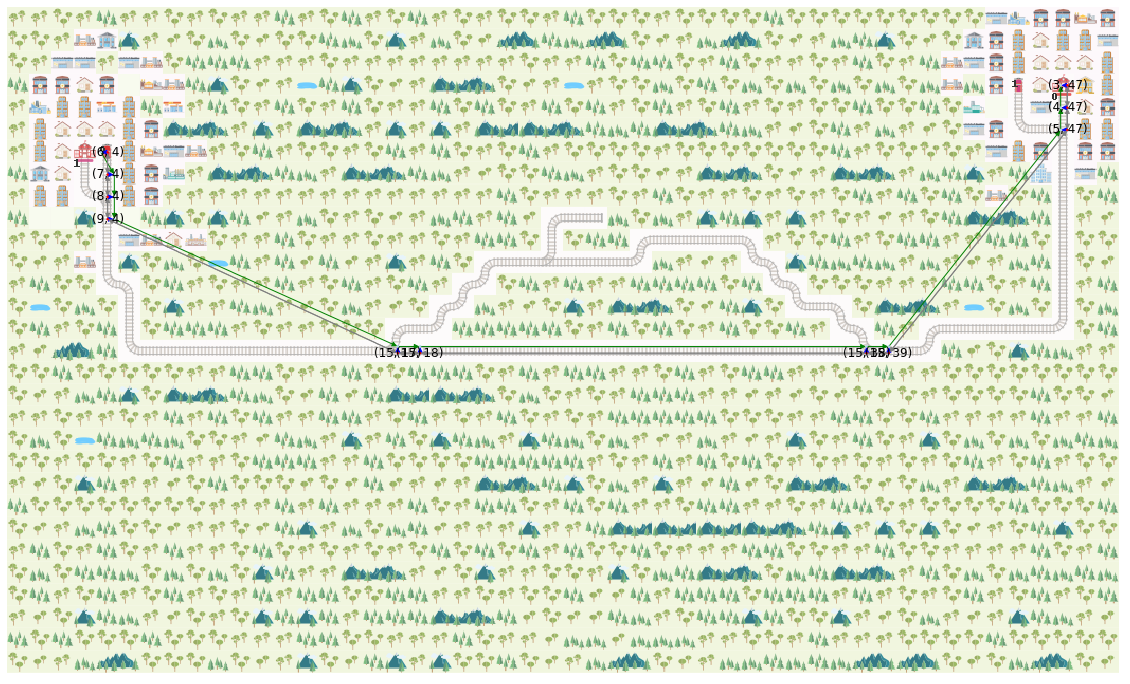

In [53]:
Gpaths = nx.compose_all(lGpaths[0:1])
lnPath = llnPaths[0]
# obtain the grid node for each rail node by cheating - just remove the "direction" from the tuple
lnGrid =  [n[:2] for n in lnPath ] 
#print(l_node_path + lnGrid)
GPath = nx.induced_subgraph(G5, lnPath + lnGrid)

gu.plotGraphEnv(GPath, env, aImg, node_size=2, show_nodes=("grid", "rail"), show_labels=("grid"), show_edges=("hold", "dir", "grid"), figsize=(20,20), alpha_img=0.8)

if False: 
    for nStart, nEnd in zip(lnStartDir, lnEndDir):
        #nStart = agent.initial_position
        #nEnd = agent.target
        plt.scatter(nStart[1], -nStart[0], color="r", s=100)
        plt.scatter(nEnd[1], -nEnd[0], color="magenta", s=100)



In [45]:
nx.induced_subgraph(G2, lnPath + lnGrid).nodes(data=True)

NodeDataView({(3, 47, 0): {'type': 'rail'}, (9, 4): {'type': 'grid'}, (5, 47, 0): {'type': 'rail'}, (6, 4, 0): {'type': 'rail'}, (5, 47): {'type': 'grid'}, (15, 39): {'type': 'grid'}, (15, 18): {'type': 'grid'}, (7, 4, 2): {'type': 'rail'}, (8, 4, 2): {'type': 'rail'}, (6, 4): {'type': 'grid'}, (15, 39, 1): {'type': 'rail'}, (4, 47): {'type': 'grid'}, (15, 38): {'type': 'grid'}, (4, 47, 0): {'type': 'rail'}, (15, 17): {'type': 'grid'}, (15, 17, 1): {'type': 'rail'}, (3, 47): {'type': 'grid'}, (15, 18, 1): {'type': 'rail'}, (9, 4, 2): {'type': 'rail'}, (7, 4): {'type': 'grid'}, (15, 38, 1): {'type': 'rail'}, (8, 4): {'type': 'grid'}})

In [28]:
import flatland.utils.graph_utils as gu

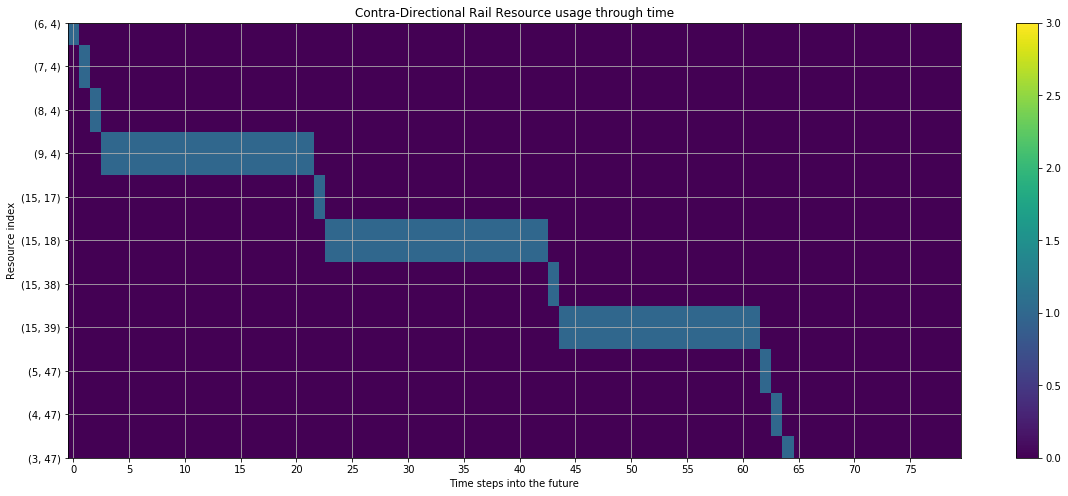

In [71]:
dRes, dlRails, dg2Dirs = gu.plotResourceUsage(G5, llnPaths=llnPaths[0:1], contradir=True, node_ticks=True, nStepsShow=80)

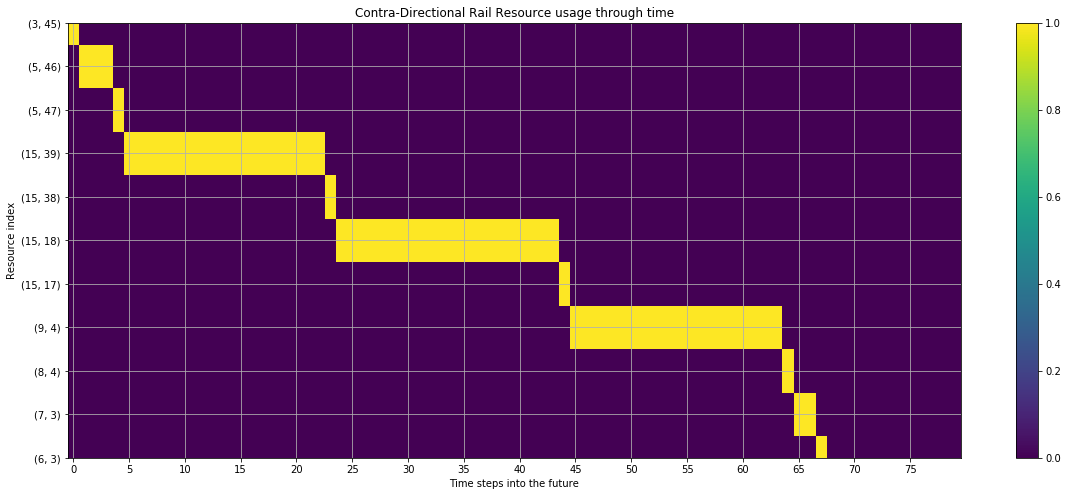

In [31]:
dRes, dlRails, dg2Dirs = gu.plotResourceUsage(G5, llnPaths=llnPaths[1:2], contradir=True, node_ticks=True, nStepsShow=80)

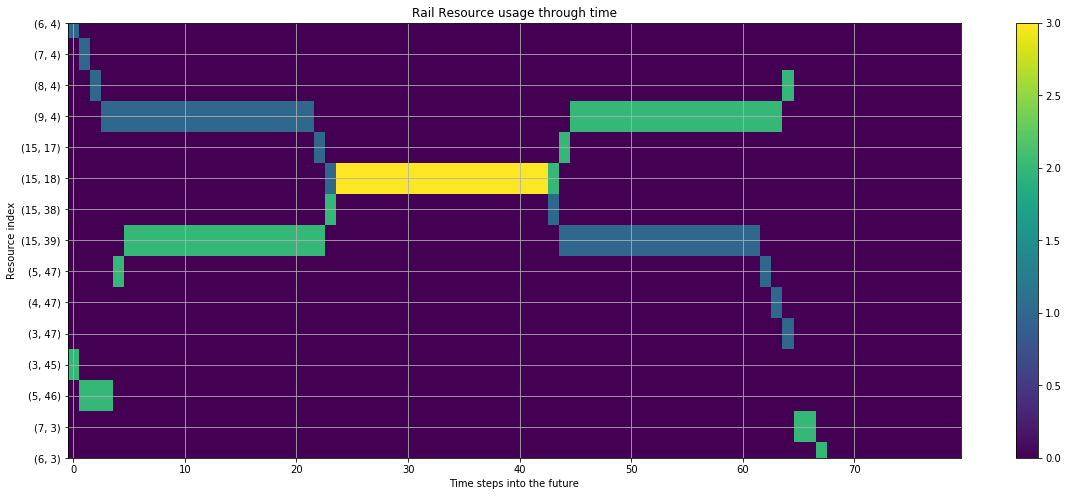

In [70]:
dRes, dlRails, dg2Dirs = gu.plotResourceUsage(G5, llnPaths=llnPaths[:], node_ticks=True, contradir=False, nStepsShow=80, agent_increment=True, vmax=3)

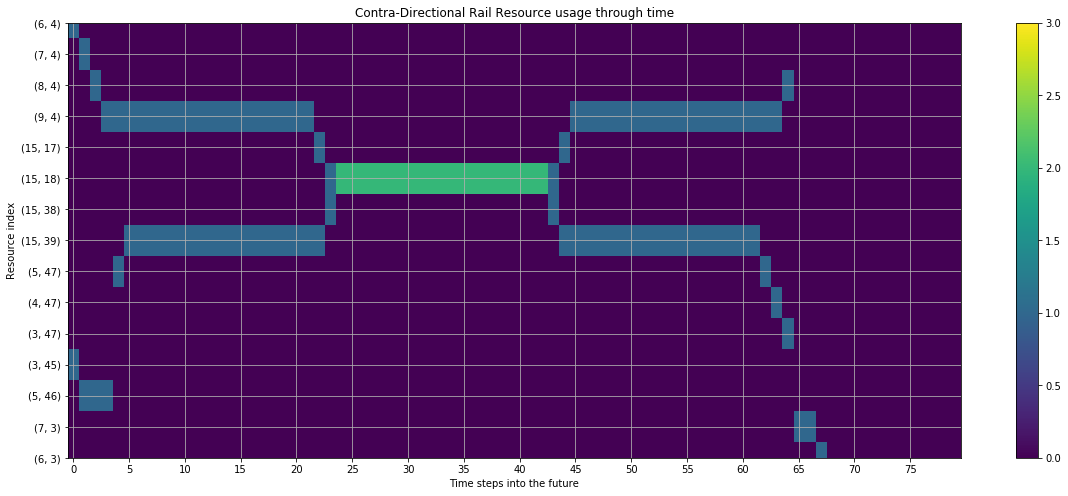

In [119]:
dRes, dlRails, dg2Dirs = gu.plotResourceUsage(G5, llnPaths=llnPaths[:], contradir=True, node_ticks=True, nStepsShow=80)

In [38]:
#print( G5.nodes()[(14,46)] )
#print( G5.nodes()[(14,46, 2)] )
#print( G5.nodes()[(26,27, 1)] )

{'type': 'grid', 'contraction': {(26, 27): {'type': 'grid'}}, 'l': 32}
{'type': 'rail', 'contraction': {(26, 27, 3): {'type': 'rail'}}}
{'type': 'rail', 'contraction': {(14, 46, 0): {'type': 'rail'}}}


In [57]:
lnStartDir, lnEndDir

([(3, 45, 0)], [(6, 3, 0)])

In [55]:
lllnHammock = []
for nStart, nTarg in lltStartTarg:
    print(nStart, nTarg)
    llnHammock = gu.hammockPaths(G5, nStart, nTarg, endSkip=3, preamble=True)
    lllnHammock.append(llnHammock)

(6, 4, 0) (3, 47, 0)
(6, 4, 0) (3, 47, 0)
(3, 45, 0) (6, 3, 0)
(3, 45, 0) (6, 3, 0)


In [58]:
G5c = nx.compose_all([ nx.induced_subgraph(G5, lnPath) for lnPath in lllnHammock[0][:1] + lllnHammock[1][1:2] ])

In [59]:
lllnHammock[1]

[[(3, 45, 0),
  (4, 45, 2),
  (5, 47, 1),
  (6, 47, 2),
  (15, 38, 3),
  (15, 37, 3),
  (15, 17, 3),
  (15, 16, 3),
  (8, 4, 0),
  (8, 3, 3),
  (6, 3, 0)],
 [(3, 45, 0),
  (4, 45, 2),
  (5, 47, 1),
  (6, 47, 2),
  (15, 38, 3),
  (14, 38, 0),
  (11, 24, 3),
  (11, 23, 3),
  (15, 17, 2),
  (15, 16, 3),
  (8, 4, 0),
  (8, 3, 3),
  (6, 3, 0)]]

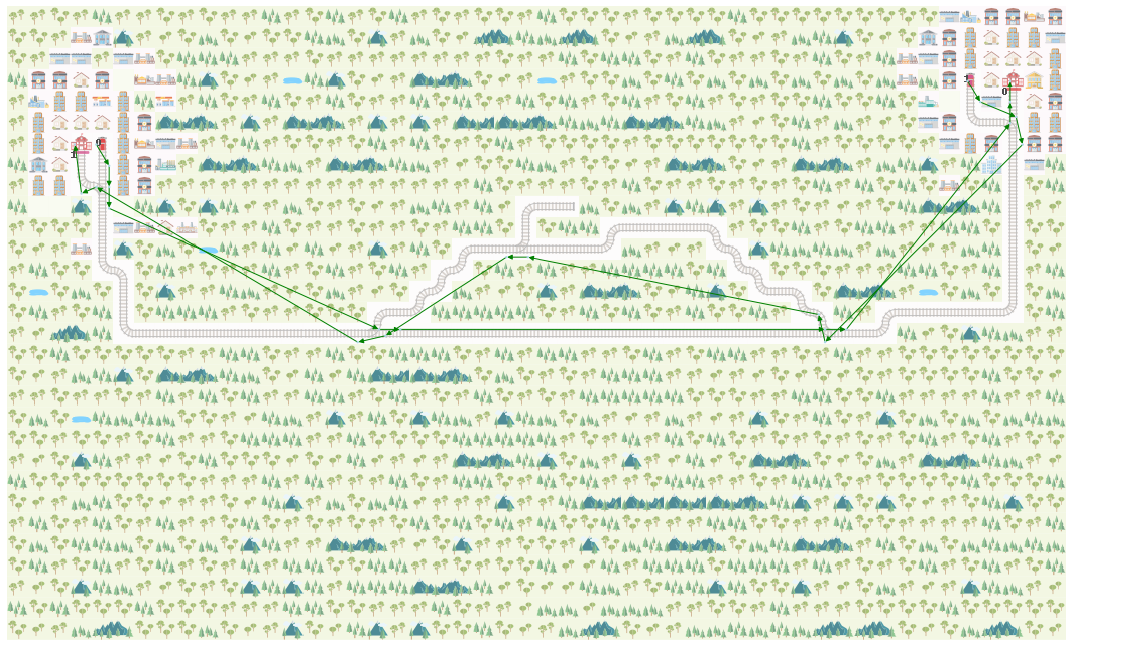

In [60]:
gu.plotGraphEnv(G5c, env, aImg, node_size=2, figsize=(20,20), alpha_img=0.7)

In [85]:
gEnv.savejson(filename="g4.json", alt_graph=G5c)

In [62]:
import flatland.utils.graph_utils as gu

### Pick an alternative route from the Hammock for Agent 1
There is now no conflict in the chart.

2


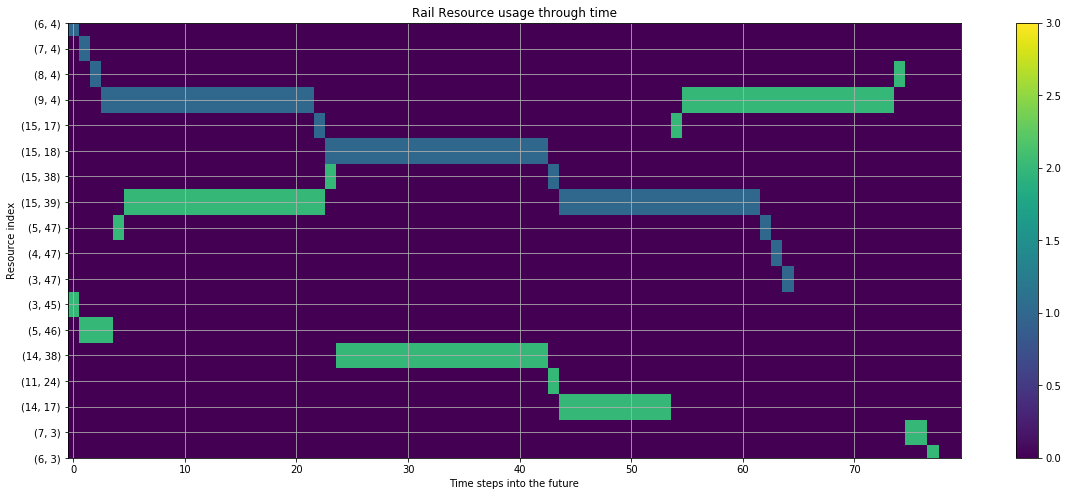

In [72]:
lln_Ag0P0_Ag1P1 = llnPaths[:1] + [lllnHammock[1][1]]
print(len(lln_Ag0P0_Ag1P1))

dRes, dlRails, dg2Dirs = gu.plotResourceUsage(G5, llnPaths=lln_Ag0P0_Ag1P1, contradir=False, node_ticks=True, nStepsShow=80, agent_increment=True)

In [116]:
lln_Ag0P0_Ag1P1


[[(6, 4, 0),
  (7, 4, 2),
  (8, 4, 2),
  (9, 4, 2),
  (15, 17, 1),
  (15, 18, 1),
  (15, 38, 1),
  (15, 39, 1),
  (5, 47, 0),
  (4, 47, 0),
  (3, 47, 0)],
 (3, 45, 0),
 (4, 45, 2),
 (5, 47, 1),
 (6, 47, 2),
 (15, 38, 3),
 (14, 38, 0),
 (11, 24, 3),
 (11, 23, 3),
 (15, 17, 2),
 (15, 16, 3),
 (8, 4, 0),
 (8, 3, 3),
 (6, 3, 0)]